# Setup

### Install Necessary Libraries

In [68]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn nltk wordcloud missingno

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)


### Import Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mazen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Initial Data Exploration of Gold Price Prediction Datasets

## 1. Introduction

In this notebook, we perform data familiarization and initial exploratory data analysis (EDA) on the datasets provided for predicting the percentage change of gold prices in Egypt. The datasets include time-series data, stock prices, economic indicators, and textual news data. Our objective is to understand the data structure, quality, and potential relationships to inform our modeling strategy.


### Data Loading

In [74]:
# Load datasets
intra_day_gold = pd.read_csv('../InputData/intraday_gold.csv')
stocks_prices_volumes = pd.read_csv('../InputData/stocks_prices_and_volumes.csv')
inflation_mom = pd.read_csv('../InputData/inflation_month_on_month.csv')
inflation_yoy = pd.read_csv('../InputData/inflation_year_on_year.csv')
interest_rates = pd.read_csv('../InputData/egyptian_corridor_interest_rates.csv')
news = pd.read_csv('../InputData/news.csv')
vix = pd.read_csv('../InputData/vix_index.csv')
vxeem = pd.read_csv('../InputData/vxeem_index.csv')
fed_funds_rate = pd.read_csv('../InputData/effective_federal_funds_rate.csv')
housing_index = pd.read_csv('../InputData/housing_index.csv')
crude_oil_prices = pd.read_csv('../InputData/crude_oil_prices.csv')

In [75]:
intra_day_gold.head()

,Timestamp,24K
0,2020-01-01T11:48:22+00:00,775.0
1,2020-01-02T13:46:59+00:00,776.0
2,2020-01-03T10:09:55+00:00,787.0
3,2020-01-03T11:29:31+00:00,789.0
4,2020-01-03T13:29:42+00:00,786.0


### Data Familiarization

In [76]:
print(f"Intra-Day Gold Data Shape: {intra_day_gold.shape}")

Intra-Day Gold Data Shape: (3017, 2)


In [77]:
intra_day_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3017 entries, 0 to 3016
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  3017 non-null   object 
 1   24K        3017 non-null   float64
dtypes: float64(1), object(1)
memory usage: 47.3+ KB


In [80]:
intra_day_gold.describe()

,24K
count,3017.000000
mean,1437.819026
std,773.140954
min,2.000000
25%,902.000000
50%,985.000000
75%,1966.000000
max,3806.000000


In [79]:
news['category'].value_counts()

category
announcements    50912
news             14477
banks            11346
stocks           10739
investment        2710
list              1205
Name: count, dtype: int64

In [84]:
duplicates = intra_day_gold.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
intra_day_gold.isnull().sum()

Number of duplicate rows: 0


Timestamp    0
24K          0
dtype: int64

In [120]:
intra_day_gold['Timestamp'] = pd.to_datetime(intra_day_gold['Timestamp'], format='mixed', utc=True, errors='coerce')
# Extract date
intra_day_gold['Date'] = intra_day_gold['Timestamp'].dt.date

# Extract time
intra_day_gold['Time'] = intra_day_gold['Timestamp'].dt.time

# Extract hour (useful for intraday analysis)
intra_day_gold['Hour'] = intra_day_gold['Timestamp'].dt.hour

In [121]:
intra_day_gold['gold_price'] = pd.to_numeric(intra_day_gold['24K'], errors='coerce')


# Initial Exploratory Data Analysis (EDA)

### Univariate Analysis

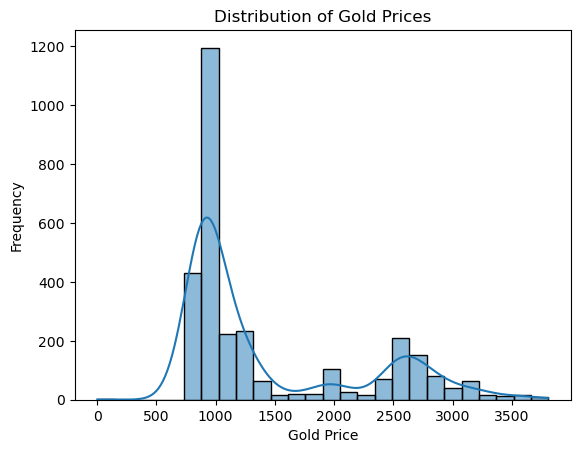

In [122]:
sns.histplot(intra_day_gold['gold_price'], kde=True)
plt.title('Distribution of Gold Prices')
plt.xlabel('Gold Price')
plt.ylabel('Frequency')
plt.show()

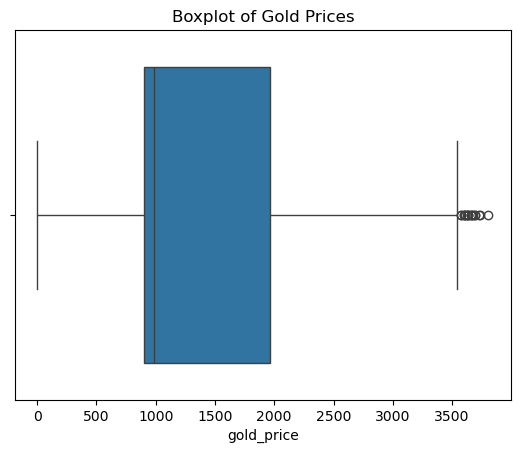

In [123]:
sns.boxplot(x=intra_day_gold['gold_price'])
plt.title('Boxplot of Gold Prices')
plt.show()


### Time-Series Analysis

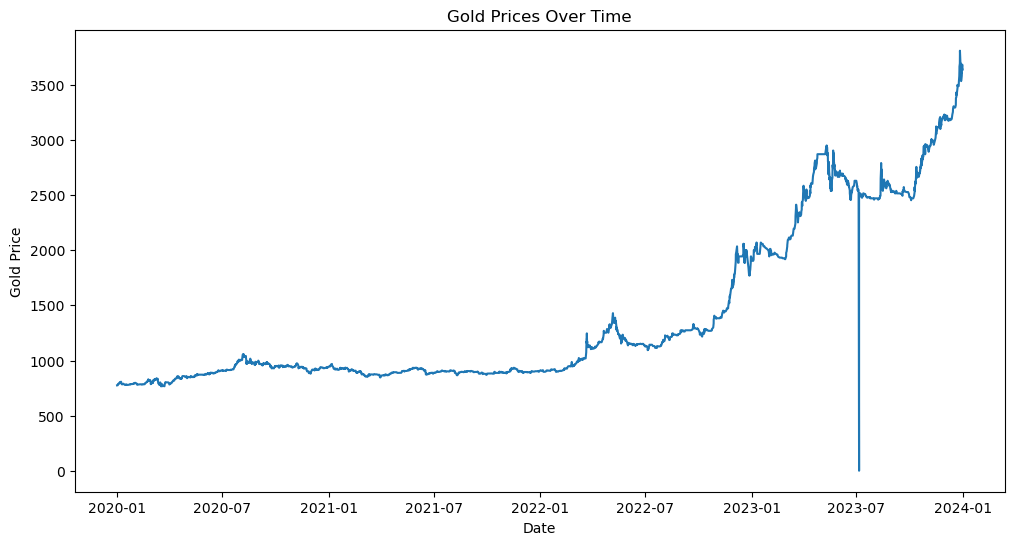

In [126]:
plt.figure(figsize=(12,6))
plt.plot(intra_day_gold['Timestamp'], intra_day_gold['gold_price'])
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.show()

In [127]:
# Interactive Time-Series Plot
fig = px.line(intra_day_gold, x='Timestamp', y='24K', title='Gold Prices Over Time (Interactive)')
fig.show()

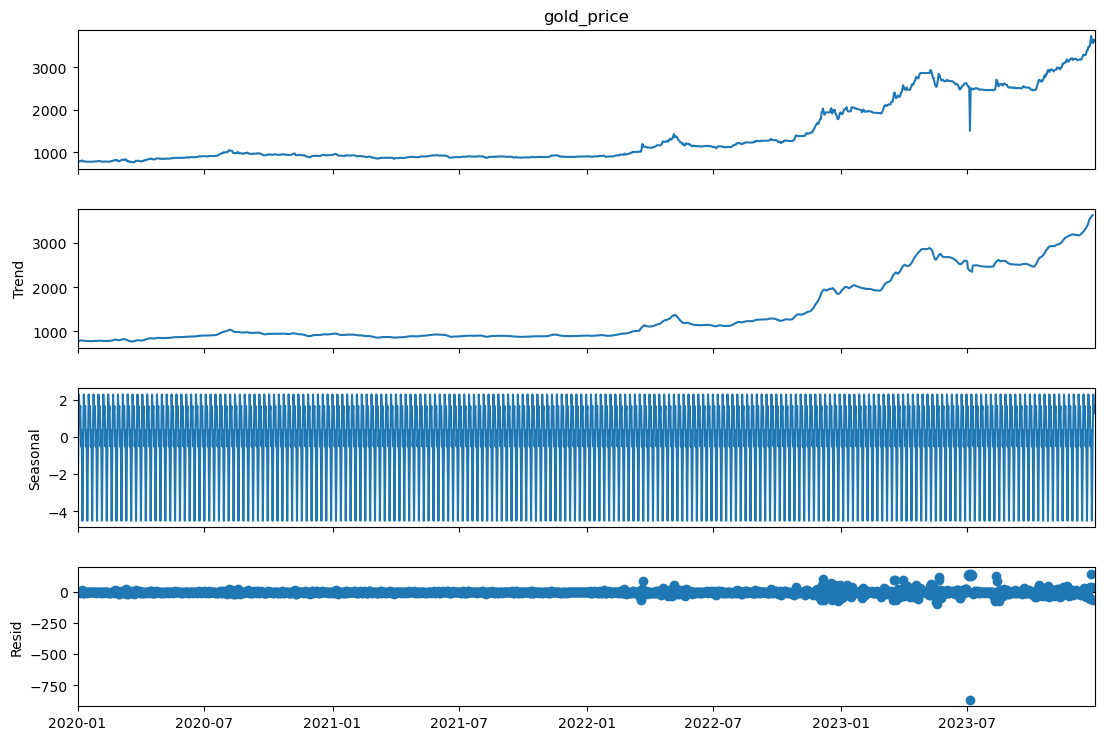

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose

gold_ts = intra_day_gold.set_index('Timestamp')['gold_price'].resample('D').mean()
decomposition = seasonal_decompose(gold_ts.dropna(), model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

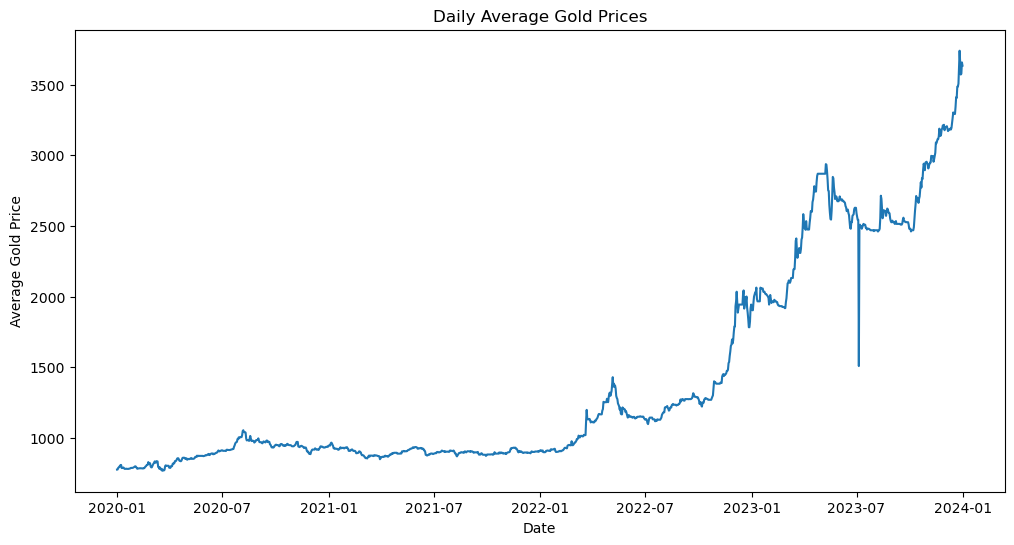

In [146]:
# Set 'Timestamp' as the index
intra_day_gold.set_index('Timestamp', inplace=True)

daily_gold_prices = intra_day_gold['gold_price'].resample('D').mean().reset_index()
daily_gold_prices.rename(columns={'gold_price': 'daily_average_gold_price'}, inplace=True)

plt.figure(figsize=(12,6))
plt.plot(daily_gold_prices['Timestamp'], daily_gold_prices['daily_average_gold_price'])
plt.title('Daily Average Gold Prices')
plt.xlabel('Date')
plt.ylabel('Average Gold Price')
plt.show()

### Bivariate and Multivariate Analysis

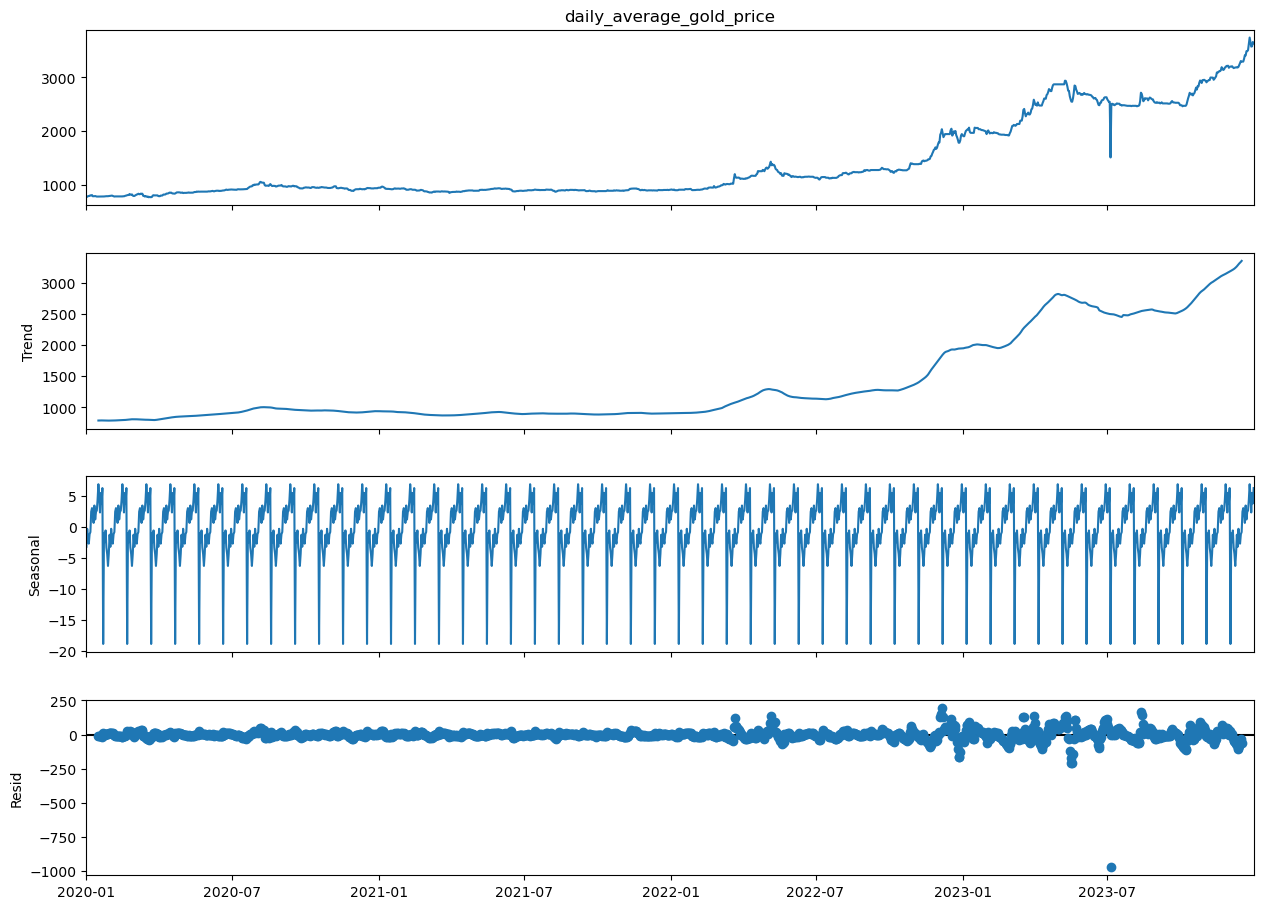

In [147]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure there are no missing dates
daily_gold_prices.set_index('Timestamp', inplace=True)
daily_gold_prices = daily_gold_prices.asfreq('D')

decomposition = seasonal_decompose(daily_gold_prices['daily_average_gold_price'], model='additive', period=30)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

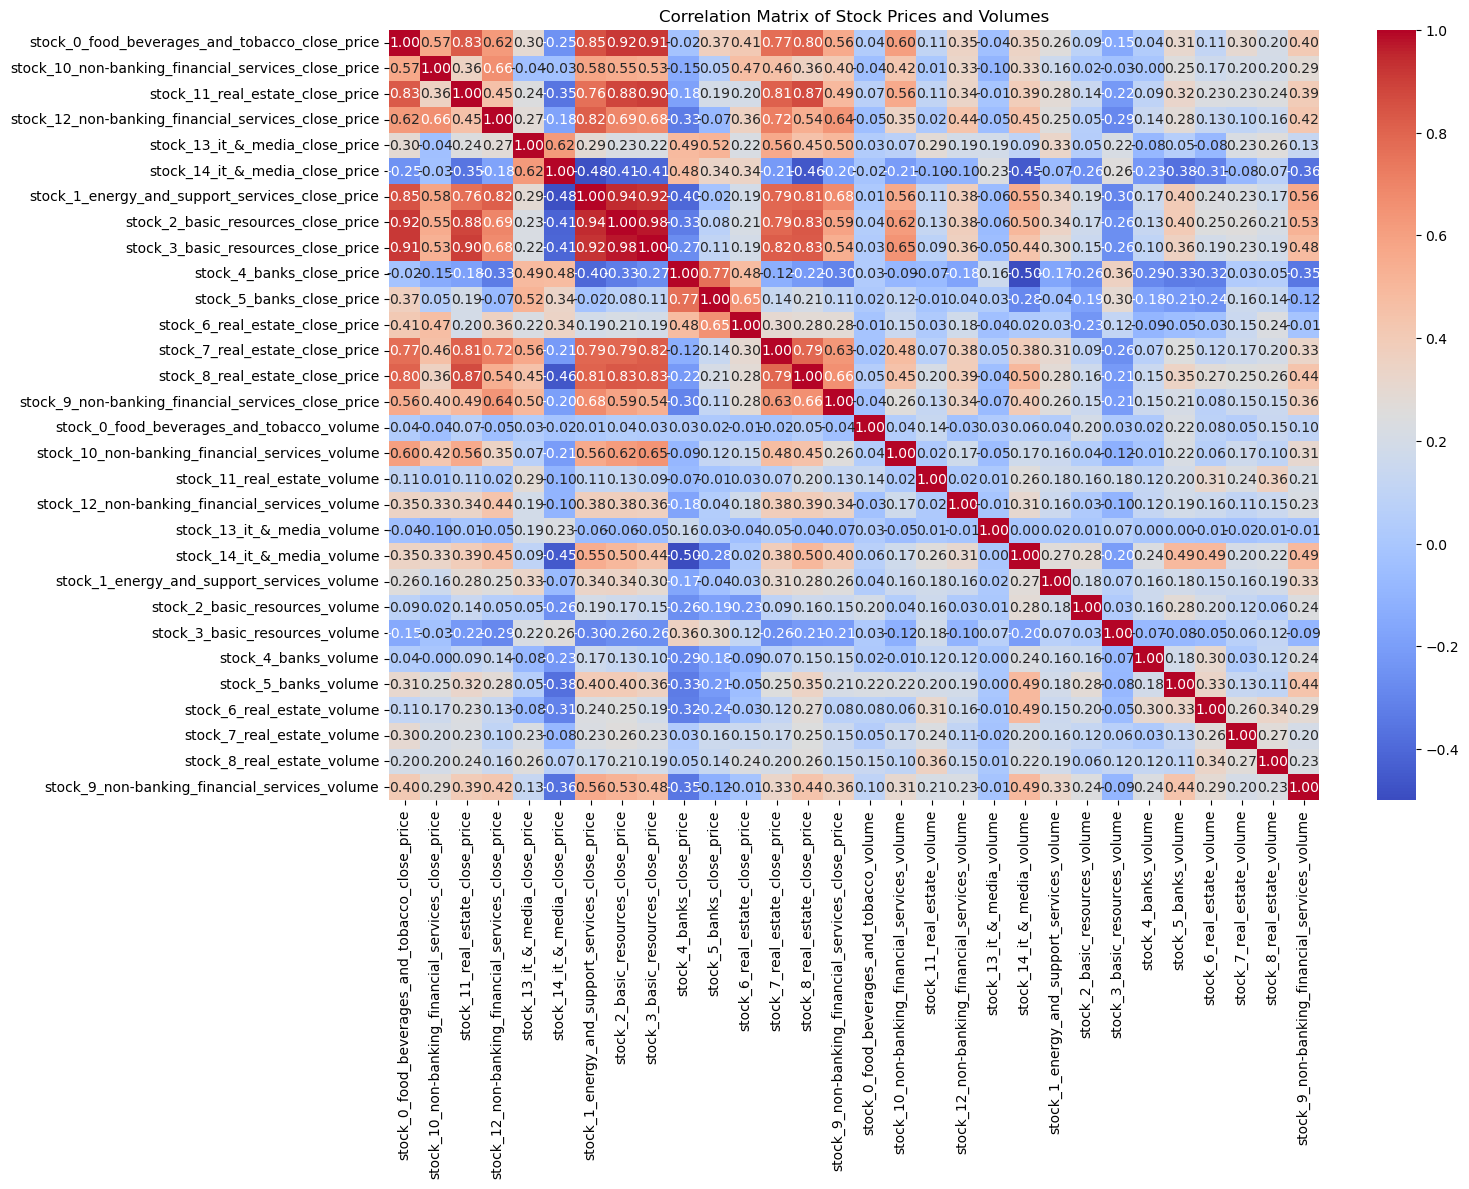

In [134]:
numeric_cols = stocks_prices_volumes.select_dtypes(include=np.number).columns
corr_matrix = stocks_prices_volumes[numeric_cols].corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Stock Prices and Volumes')
plt.show()

In [153]:
# Reset index if necessary
daily_gold_prices.reset_index(inplace=True)
daily_gold_prices.rename(columns={'Timestamp': 'Date'}, inplace=True)

# Merge on 'date'
merged_data = pd.merge(daily_gold_prices, stocks_prices_volumes, on='Date', how='inner')

ValueError: cannot insert level_0, already exists

In [135]:
sns.scatterplot(x='some_stock_price', y='gold_price', data=merged_data)
plt.title('Gold Price vs. Stock Price')
plt.show()

NameError: name 'merged_data' is not defined

### Text Data Analysis

In [101]:
news['date'] = pd.to_datetime(news['date'])
articles_per_day = news.groupby(news['date'].dt.date).size()

plt.figure(figsize=(12,6))
articles_per_day.plot()
plt.title('Number of News Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

C:\Users\Mazen\AppData\Local\Temp\ipykernel_30808\3304174810.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news['date'] = pd.to_datetime(news['date'])


DateParseError: hour must be in 0..23: 50:00.0, at position 1

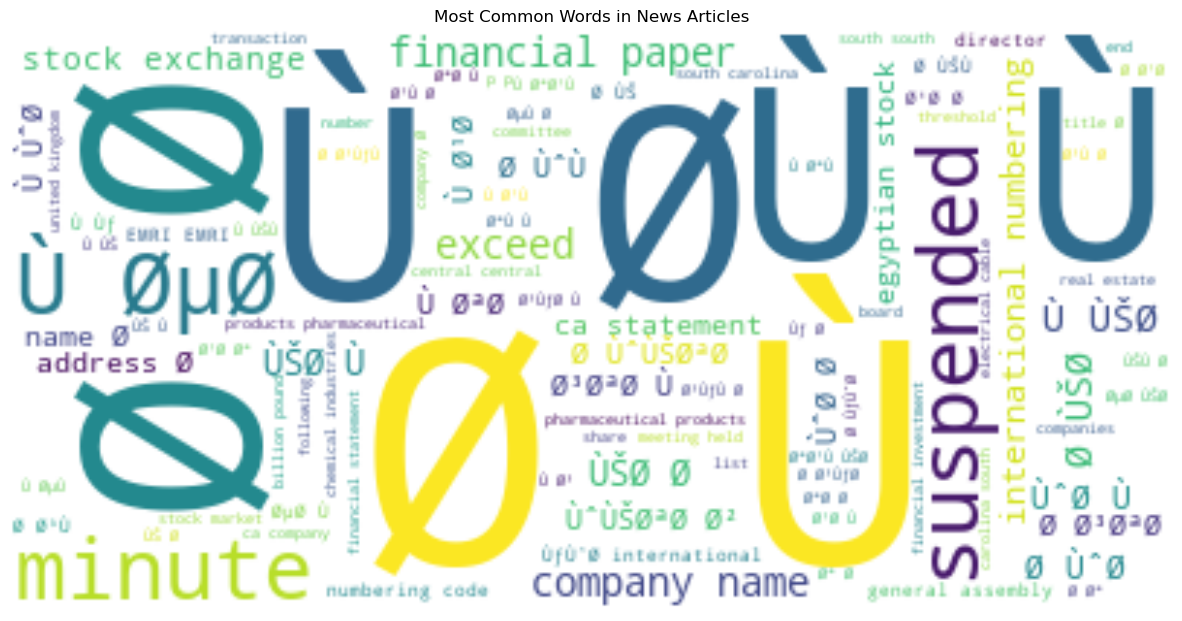

In [103]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Combine all content into one string
text_content = ' '.join(news['translated_title'].dropna().astype(str))

# WordCloud
wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(text_content)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in News Articles')
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mazen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


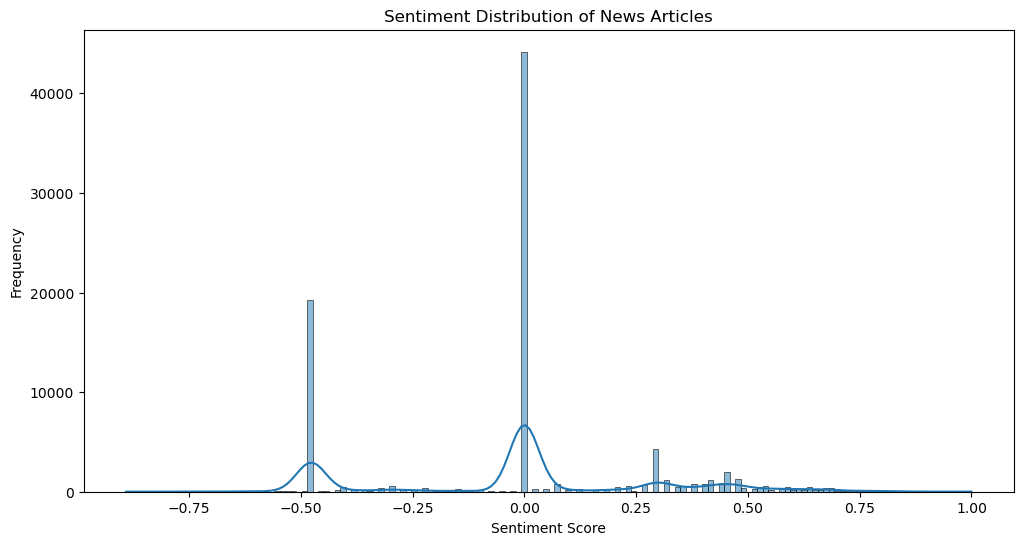

In [105]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
news['sentiment'] = news['translated_title'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

plt.figure(figsize=(12,6))
sns.histplot(news['sentiment'], kde=True)
plt.title('Sentiment Distribution of News Articles')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Data Alignment

In [109]:
print(f"Intra-Day Gold Date Range: {intra_day_gold['Timestamp'].min()} to {intra_day_gold['Timestamp'].max()}")
print(f"Stocks Data Date Range: {stocks_prices_volumes['Date'].min()} to {stocks_prices_volumes['Date'].max()}")

Intra-Day Gold Date Range: 2020-01-01T11:48:22+00:00 to 2023-12-31 00:00:00
Stocks Data Date Range: 2020-01-01 to 2023-12-30


In [110]:
gold_dates = set(intra_day_gold['Timestamp'].dt.date.unique())
stock_dates = set(stocks_prices_volumes['Date'].dt.date.unique())
common_dates = gold_dates.intersection(stock_dates)
print(f"Number of Common Dates: {len(common_dates)}")

AttributeError: Can only use .dt accessor with datetimelike values

# Findings

### Observations from Univariate Analysis

- The gold prices exhibit right-skewness, indicating occasional high price spikes.
- There are some outliers in the gold price data that may need further investigation.


# Potential Issues and Solutions

### Data Quality Issues and Proposed Solutions

- **Missing Values**: There are missing values in the gold price data. We can consider imputation methods like forward fill or interpolation.
- **Outliers**: Significant outliers detected in stock prices. We need to determine if these are errors or legitimate extreme values.
- **Date Alignment**: Not all datasets cover the same date range. We'll need to focus on the overlapping periods or consider extrapolation methods.


# Next Steps

## Next Steps

- **Data Cleaning**: Address missing values and outliers in all datasets.
- **Feature Engineering**: Create lag features, rolling statistics, and extract sentiment scores from news data.
- **Data Integration**: Merge datasets on the date column to prepare for modeling.
- **Model Selection**: Explore different modeling approaches suitable for time-series data.
